In [1]:
#Disclaimer: The majority of the scraping framework was inspired by Riley Predum's post: https://towardsdatascience.com/web-scraping-craigslist-a-complete-tutorial-c41cea4f4981

import os
import glob
import pandas as pd

citystr = 'minneapolis' 
aptfiles = glob.glob('./scraped_data/apts_'+citystr+'*')

try:
    del apts
except:
    print('no apts in memory, loading some...')

for file in aptfiles:
    try: 
        apts = apts.append(pd.read_csv(file),ignore_index=True)
    except:
        apts = pd.read_csv(file)

apts = apts.drop_duplicates(subset=['price','sqft','number bedrooms','laundry','parking','zips','types','neighborhoods'])
apts = apts[apts['sqft']>400]
apts = apts[apts['sqft']<2000]
apts = apts[apts['price']>559]
apts = apts[apts['price']<2500]
apts = apts[apts['price'] / apts['number bedrooms'] > 400]

print(str(apts.shape[0])+' unique listings available.')

no apts in memory, loading some...
4621 unique listings available.


In [2]:
import numpy as np
from operator import itemgetter
from uszipcode import SearchEngine

search = SearchEngine(simple_zipcode=False)
apt = apts.iloc[0]
zipcode = search.by_zipcode(str(apt['zips']))
zipDict = zipcode.to_dict()
NaN = np.nan
if 'medianIncome' not in apts.columns:
    print('Adding data from zipcode API (median household income, age demographics, etc.) ...')
    apts['medianIncome'] = NaN
    apts = pd.concat([apts,pd.DataFrame(columns=list(map(itemgetter('x'), zipDict['population_by_age'][2]['values'])))])
    apts['medianHomeValue'] = NaN
    apts['postdateint'] = NaN
    
for index, apt in apts.iterrows():
    zipcode = search.by_zipcode(str(apt['zips']))
    zipDict = zipcode.to_dict()
    income = zipDict['median_household_income']
    if income is not None:
        apts.loc[index,'medianIncome'] = np.float(income)
        
    homeValue = zipDict['median_home_value']
    if homeValue is not None:
        apts.loc[index,'medianHomeValue'] = np.float(income)
        
    if zipDict['population_by_age'] is not None:
        popsByAge = list(map(itemgetter('y'), zipDict['population_by_age'][2]['values'] ))
        apts.loc[index,list(map(itemgetter('x'), zipDict['population_by_age'][2]['values']))] = np.array(popsByAge) / zipDict['population']
    
    apts.loc[index,'postdateint'] = np.int(apt['posted'].split('-')[0]+apt['posted'].split('-')[1]+apt['posted'].split('-')[2].split(' ')[0])
    
apts['pYouths'] = apts[['Under 5', '5-9', '10-14','15-19']].sum(axis=1)
apts['pTwenties'] = apts[['20-24','25-29']].sum(axis=1)
apts['pThirties'] = apts[['30-34','35-39']].sum(axis=1)
apts['pForties'] = apts[['40-44','45-49']].sum(axis=1)
apts['pFifties'] = apts[['50-54','55-59']].sum(axis=1)
apts['pSixtyPlus'] = apts[['60-64','65-69','70-74','75-79','80-84','85 Plus']].sum(axis=1)

Adding data from zipcode API (median household income, age demographics, etc.) ...


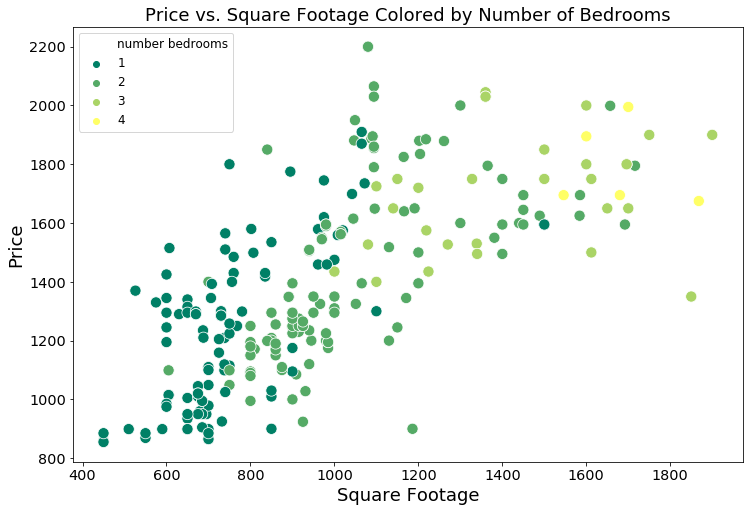

In [3]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12, 8))
sns.scatterplot(x='sqft', y='price', hue='number bedrooms', palette='summer', x_jitter=True, y_jitter=True, s=125, data=apts.dropna())
plt.legend(fontsize=12)
plt.xlabel("Square Footage", fontsize=18)
plt.ylabel("Price", fontsize=18);
plt.title("Price vs. Square Footage Colored by Number of Bedrooms", fontsize=18);


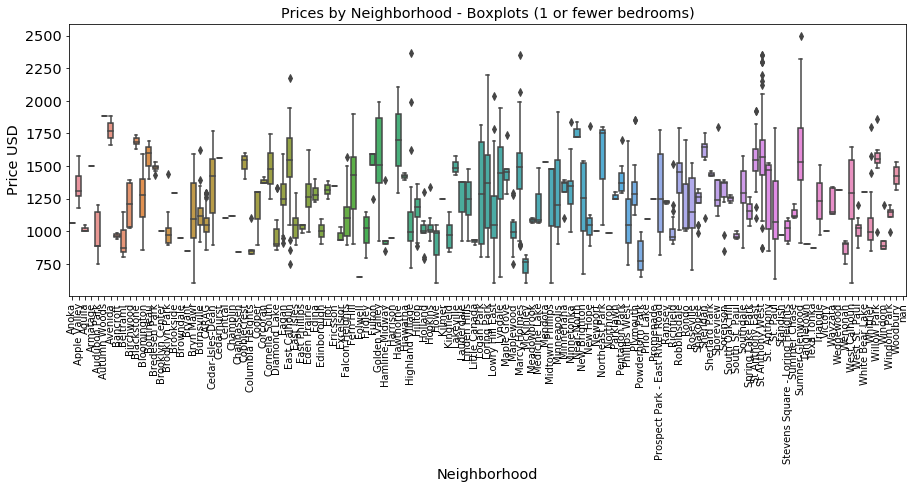

In [4]:
brlim = 1
sns.boxplot(x='neighborhoods', y='price', data=apts[apts['number bedrooms']<=brlim],
            order=sorted(apts[(apts['number bedrooms']<=brlim)]['neighborhoods'].astype('str').unique()))
plt.xlabel("Neighborhood");
plt.xticks(rotation=90,size=10)
plt.ylabel("Price USD");
plt.title("Prices by Neighborhood - Boxplots ("+str(brlim)+" or fewer bedrooms)");

In [5]:
#drop incomplete rows, recode categorical variables

#specify main columns of interest
maincols = ['number bedrooms',
            'sqft',
            'medianIncome',
            'pYouths',
            'pTwenties',
            'pThirties',
            'pForties',
            'pFifties',
            'pSixtyPlus',
            'postdateint']

# drop problematic 
apts = apts.dropna(subset=maincols+['cities','neighborhoods','types','laundry','parking'])

# recode categorical variables
apts_onehot = apts.copy()
apts_onehot = pd.get_dummies(apts_onehot, columns=['cities'], prefix = ['ct'])
apts_onehot = pd.get_dummies(apts_onehot, columns=['neighborhoods'], prefix = ['nb'])
apts_onehot = pd.get_dummies(apts_onehot, columns=['types'], prefix = ['ty'])
apts_onehot = pd.get_dummies(apts_onehot, columns=['laundry'], prefix = ['ld'])
apts_onehot = pd.get_dummies(apts_onehot, columns=['parking'], prefix = ['pk'])
apts_onehot['parking'] = apts['parking']
apts_onehot['laundry'] = apts['laundry']
apts_onehot['cities'] = apts['cities']
apts_onehot['neighborhoods'] = apts['neighborhoods']

print(apts_onehot[['laundry','ld_1.0','ld_2.0','ld_3.0','ld_4.0']].head(20))

    laundry  ld_1.0  ld_2.0  ld_3.0  ld_4.0
0       1.0       1       0       0       0
1       1.0       1       0       0       0
2       3.0       0       0       1       0
3       1.0       1       0       0       0
4       3.0       0       0       1       0
6       1.0       1       0       0       0
7       1.0       1       0       0       0
8       1.0       1       0       0       0
14      4.0       0       0       0       1
18      1.0       1       0       0       0
19      1.0       1       0       0       0
20      1.0       1       0       0       0
21      1.0       1       0       0       0
22      3.0       0       0       1       0
23      3.0       0       0       1       0
25      3.0       0       0       1       0
27      3.0       0       0       1       0
30      4.0       0       0       0       1
34      3.0       0       0       1       0
35      1.0       1       0       0       0


In [6]:
#define labels and features
tycols = [col for col in apts_onehot if col.startswith('ty')]
for c in tycols:
    maincols.append(c) 
pkcols = [col for col in apts_onehot if col.startswith('pk')]
for c in pkcols:
    maincols.append(c) 
ldcols = [col for col in apts_onehot if col.startswith('ld')]
for c in ldcols:
    maincols.append(c) 

prices = np.array(apts_onehot['price'])
features = np.array(apts_onehot[maincols])
features_avg = features.mean(axis=0)
features_std = features.std(axis=0)
features = (features - features_avg) / features_std
feature_list = list(apts_onehot[maincols])

In [7]:
from sklearn import linear_model, model_selection

#Ridge regression
ridge = linear_model.Ridge()
parameters = {'alpha': [.005, .01, .025, .05, .10, .5, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048]}
rr = model_selection.GridSearchCV(ridge, parameters, scoring='neg_mean_squared_error',cv=10)
rr.fit(y=prices,X=features)
print("Number observations: "+str(features.shape[0]))
print("Ridge params (best): "+str(rr.best_params_))
print("Ridge score (best): "+str(rr.best_score_))
apts_onehot['price_est_rr'] = rr.predict(features)
apts_onehot['price_dif_rr'] = apts_onehot['price']-apts_onehot['price_est_rr']
apts_onehot['price_difpct_rr'] = (apts_onehot['price_dif_rr'] / apts_onehot['price_est_rr']) * 100

Number observations: 3648
Ridge params (best): {'alpha': 64}
Ridge score (best): -46351.31131568726


In [8]:

# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = model_selection.train_test_split(features, 
                                                                                            prices, 
                                                                                            test_size = 0.20, 
                                                                                            random_state = 13)
print('Number training features: '+str(train_features.shape[0]))
print('Number test features: '+str(test_features.shape[0]))

Number training features: 2918
Number test features: 730


In [9]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators = 1000, random_state = 13)
rf.fit(train_features, train_labels)
predictions = rf.predict(test_features)
errors = abs(predictions - test_labels)
print('Mean Absolute Error: $'+str(round(np.mean(errors), 2)))
mape = np.mean(100 * (errors / test_labels))
print('Mean Absolute Percentage Error (MAPE): '+str(round(mape,2))+'%')
accuracy = 100 - mape
print('Accuracy:', round(accuracy, 2), '%')

Mean Absolute Error: $115.26
Mean Absolute Percentage Error (MAPE): 8.24%
Accuracy: 91.76 %


In [10]:
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot

# Pull out one tree from the forest
tree = rf.estimators_[13]

# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_list, rounded = True, precision = 1)

# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')

# Write graph to a png file
graph.write_png('tree.png')


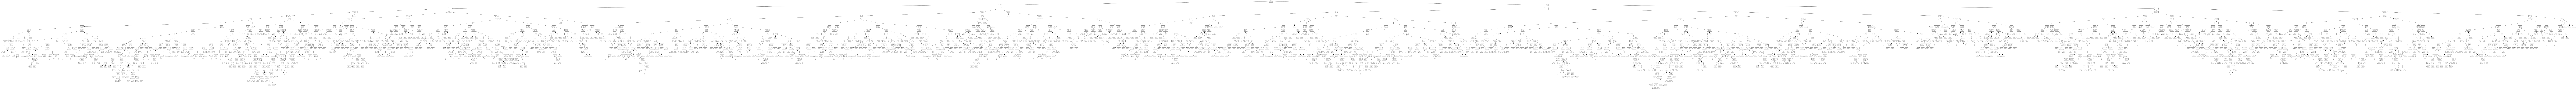

In [11]:
from IPython.display import Image 
Image("tree.png")

In [12]:

# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: sqft                 Importance: 0.48
Variable: ld_1.0               Importance: 0.2
Variable: pYouths              Importance: 0.07
Variable: number bedrooms      Importance: 0.04
Variable: postdateint          Importance: 0.04
Variable: pTwenties            Importance: 0.03
Variable: medianIncome         Importance: 0.02
Variable: pThirties            Importance: 0.02
Variable: pForties             Importance: 0.02
Variable: pFifties             Importance: 0.01
Variable: pSixtyPlus           Importance: 0.01
Variable: ty_1.0               Importance: 0.01
Variable: pk_1.0               Importance: 0.01
Variable: pk_2.0               Importance: 0.01
Variable: pk_4.0               Importance: 0.01
Variable: ty_2.0               Importance: 0.0
Variable: ty_3.0               Importance: 0.0
Variable: ty_4.0               Importance: 0.0
Variable: ty_5.0               Importance: 0.0
Variable: ty_6.0               Importance: 0.0
Variable: ty_8.0               Importance: 0.0

In [13]:
pd.options.display.max_colwidth = 200
pd.options.display.max_rows = 600

apts_onehot['price_est_rf'] = rf.predict(features)
apts_onehot['price_dif_rf'] = apts_onehot['price']-apts_onehot['price_est_rf']
apts_onehot['price_difpct_rf'] = (apts_onehot['price_dif_rf'] / apts_onehot['price_est_rf']) * 100

apts_onehot[(apts_onehot['parking'] <=4 ) &
            ((apts_onehot['laundry']==1) | (apts_onehot['laundry']==3) | (apts_onehot['laundry']==4)) & 
            (apts_onehot['sqft']>=599) & 
            (apts_onehot['price']<=1400) & 
            ((apts_onehot['cities']=='Minneapolis') | (apts_onehot['cities']=='Robbinsdale') |
             (apts_onehot['cities']=='Saint Louis Park') | (apts_onehot['cities']=='Richfield') |
             (apts_onehot['cities']=='St. Anthony') | (apts_onehot['cities']=='St. Paul')) &
            (apts_onehot.index>=np.round(np.percentile(apts_onehot.index,85)))].sort_values('posted',ascending=False)[['posted','neighborhoods','URL','price_difpct_rr','price_difpct_rf']] 

,posted,neighborhoods,URL,price_difpct_rr,price_difpct_rf
16712,2020-07-29 13:38:00,CARAG,https://minneapolis.craigslist.org/hnp/apa/d/south-minneapolis-uptown-neighborhood/7154616119.html,-6.050683,-0.124862
16719,2020-07-29 13:30:00,Near-North,https://minneapolis.craigslist.org/hnp/apa/d/minneapolis-cute-2-bedroom-home-section/7168118249.html,18.433866,0.869043
16727,2020-07-29 13:21:00,Highland Village,https://minneapolis.craigslist.org/ram/apa/d/saint-paul-excellent-location-in/7168111988.html,-1.368612,2.151738
16578,2020-07-29 12:55:00,CARAG,https://minneapolis.craigslist.org/hnp/apa/d/minneapolis-spacious-2-br-in-quiet-and/7166774370.html,0.446125,0.166299
16753,2020-07-29 12:55:00,CARAG,https://minneapolis.craigslist.org/hnp/apa/d/minneapolis-spacious-2-br-in-quiet-and/7166774370.html,0.446125,0.166299
16762,2020-07-29 12:45:00,CARAG,https://minneapolis.craigslist.org/hnp/apa/d/minneapolis-1-bedroom-apartment-in/7154616660.html,-9.633343,-1.235599
16769,2020-07-29 12:41:00,CARAG,https://minneapolis.craigslist.org/hnp/apa/d/minneapolis-one-bedrooms-at-south-mpls/7154615803.html,-9.779538,-0.329109
16770,2020-07-29 12:39:00,Diamond Lake,https://minneapolis.craigslist.org/hnp/apa/d/minneapolis-tranquil-locaton-across/7168038408.html,-4.380393,1.385704
16775,2020-07-29 12:34:00,St. Anthony,https://minneapolis.craigslist.org/ram/apa/d/minneapolis-large-updated-one-bedroom/7156477446.html,4.855087,-1.568599
16784,2020-07-29 12:29:00,Audubon Park,https://minneapolis.craigslist.org/hnp/apa/d/minneapolis-lovely-2-br-duplexpvt/7168074699.html,-16.865649,-0.888750


In [14]:
newZipCode = 55405                 #int
newSqFt = 540.                     #float
numBeds = 1.                       #float
postDateInt = 20200627             #int
typeListing = 'apartment'          #'apartment','condo','cottage/cabin','duplex','flat','house','in-law','loft','townhouse','manufactured','assisted living','land'
typeLaundry = 'laundry in bldg'    #'w/d in unit','w/d hookups','laundry in bldg','laundry on site','no laundry on site'
typeParking = 'off-street parking' #'carport','attached garage','detached garage','off-street parking','street parking','valet parking','no parking'

#get zipcode related info
zipcode = search.by_zipcode(newZipCode)
zipDict = zipcode.to_dict()
income = zipDict['median_household_income']
popsByAge = list(map(itemgetter('y'), zipDict['population_by_age'][2]['values'] ))
popsByAge = np.array(popsByAge) / zipDict['population']
pYouths = popsByAge[0:3].sum()
pTwenties = popsByAge[4:5].sum()
pThirties = popsByAge[6:7].sum()
pForties = popsByAge[8:9].sum()
pFifties = popsByAge[10:11].sum()
pSixtyPlus = popsByAge[12:17].sum()

TypeDict = {
    'apartment': 1, 
    'condo':2, 
    'cottage/cabin':3, 
    'duplex':4, 
    'flat':5, 
    'house':6, 
    'in-law':7, 
    'loft':8, 
    'townhouse':9, 
    'manufactured':10, 
    'assisted living':11, 
    'land':12
}
LaundryDict = {
    'w/d in unit':1,
    'w/d hookups':2,
    'laundry in bldg':3,
    'laundry on site':4,
    'no laundry on site':5
}    
ParkingDict = {
    'carport':1,
    'attached garage':2,
    'detached garage':3,
    'off-street parking':4,
    'street parking':5,
    'valet parking':6,
    'no parking':7
}

#append a new data frame to the old one including 
newApt = pd.DataFrame({
    'zipcode':[newZipCode],
    'sqft':[newSqFt],
    'number bedrooms':[numBeds],
    'postdateint':[postDateInt],
    'types':[np.float(TypeDict[typeListing])],
    'parking':[np.float(ParkingDict[typeParking])],
    'laundry':[np.float(LaundryDict[typeLaundry])],
    'medianIncome':[income],
    'pYouths':[pYouths],
    'pTwenties':[pTwenties],
    'pThirties':[pThirties],
    'pForties':[pForties],
    'pFifties':[pFifties],
    'pSixtyPlus':[pSixtyPlus]})
newApt_onehot = newApt
newApt_onehot = pd.get_dummies(newApt_onehot, columns=['types'], prefix = ['ty'])
newApt_onehot = pd.get_dummies(newApt_onehot, columns=['laundry'], prefix = ['ld'])
newApt_onehot = pd.get_dummies(newApt_onehot, columns=['parking'], prefix = ['pk'])
print(newApt_onehot)



   zipcode   sqft  number bedrooms  postdateint  medianIncome   pYouths  \
0    55405  540.0              1.0     20200627         48913  0.158134   

   pTwenties  pThirties  pForties  pFifties  pSixtyPlus  ty_1.0  ld_3.0  \
0   0.107066   0.101875  0.068198   0.06424    0.099215       1       1   

   pk_4.0  
0       1  


In [15]:
apts_onehot = apts_onehot.append(newApt_onehot,ignore_index=True)

new_features = apts_onehot.iloc[[-1,]].fillna(0.)[maincols].values
new_features = (new_features - features_avg) / features_std
print('Ridge prediction: $'+str(int(rr.predict(new_features)[0])))
print('Random forest prediction: $'+str(int(rf.predict(new_features)[0])))

Ridge prediction: $984
Random forest prediction: $979
